# **Importing Packages & Dependencies**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
import html

import pandas as pd
import numpy as np
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

import gensim

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# **Mounting Google drive**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# **Imporing data from Google Drive**

In [3]:
! unzip '/gdrive/My Drive/Datasets/Toxic Comment Classification Challenge/train.csv.zip' -d /content/dataset

Archive:  /gdrive/My Drive/Datasets/Toxic Comment Classification Challenge/train.csv.zip
  inflating: /content/dataset/train.csv  


In [4]:
train = pd.read_csv("/content/dataset/train.csv")

# **Exploring Data**

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#sample text to visualize
train["comment_text"][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

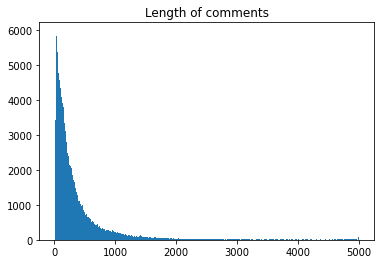

In [7]:
# visualizing length of comments using histogram plot
sentences_length = [len(sentence) for sentence in train["comment_text"] ]
plt.hist(sentences_length , bins = 500 )
plt.title("Length of comments")
plt.show()

In [8]:
feature = train.drop(["id","comment_text"],axis = 1)

In [9]:
# aggregating counts of each class of comments 
counts = []
categories = list(feature.columns)
for i in categories :
  counts.append((i,feature[i].sum()))

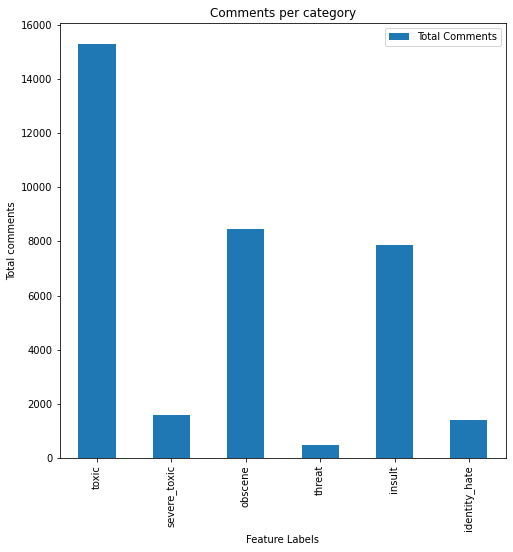

In [10]:
# converting list of tuples into dataframe for visualizing comments per category
df_1 = pd.DataFrame(counts , columns = ['Feature Labels', 'Total Comments'])
df_1.plot(x = "Feature Labels" , y = "Total Comments" , kind = "bar" , figsize = (8,8))
plt.title("Comments per category")
plt.xlabel('Feature Labels')
plt.ylabel('Total comments')
plt.show()

# **Text preprocessing**

In [11]:
import string

# defining function to remove special characters from text
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

# defining function to remove punctuation
def remove_puctuation(text) :
  translator = str.maketrans('','',string.punctuation)
  return text.translate(translator)

# defining function to convert text into lower case
def to_lowercase(text) :
  return text.lower()

# replacing numbers with texual representaion
def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

# removing white spaces
def remove_whitespaces(text) :
  return text.strip()

def text2words(text):
    return word_tokenize(text)

def remove_stopwords(words, stop_words):
  return [word for word in words if word not in stop_words]

def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


def clean_text(text) :
  text = remove_special_chars(text)
  text = remove_puctuation(text)
  text = to_lowercase(text)
  text = replace_numbers(text)
  words =  text2words(text)
  words = remove_stopwords(words, stop_words)
  words = lemmatize_words(words)
  words = lemmatize_verbs(words)
  return ''.join(words)


train["comment_text"] = train["comment_text"].apply(lambda x : clean_text(x))
train["comment_text"].head()


0    explanation edit make username hardcore metall...
1    daww match background colour im seemingly stic...
2    hey man im really try edit war guy constantly ...
3    cant make real suggestion improvement wonder s...
4                  sir hero chance remember page thats
Name: comment_text, dtype: object

# **Vectorizing words BOW**

In [12]:
tok = Tokenizer(oov_token='UNK')
tok.fit_on_texts(train['comment_text'] )
# Extract binary BoW features
x_train = tok.texts_to_sequences(train['comment_text'])

vocab_size = len(tok.word_index) + 1

In [13]:
 len(tok.word_index)

208756

# **Visualizing models performance**

In [14]:
def plot_curves(model,name_of_model) :
  history_dict = model.history
  history_dict.keys()
  acc = model.history["accuracy"]
  val_acc = model.history["val_accuracy"]
  loss = model.history["loss"]
  val_loss = model.history["val_loss"]

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, marker ='o', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, marker ='v', label='Validation loss')
  plt.title('Training and validation loss for {} model'.format(name_of_model))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  plt.plot(epochs, acc, marker ='o', label='Training auc')
  plt.plot(epochs, val_acc, marker ='v', label='Validation auc')
  plt.title('Training and validation accuracy for {} model'.format(name_of_model))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# **Padding sequences**

In [15]:
maxlen = max([len(t) for t in x_train])
avg_len = np.mean([len(t) for t in x_train])
print("max length of comments = {}".format(maxlen))
print("Average length of comments = {}".format(avg_len))

max length of comments = 1250
Average length of comments = 34.40939143077376


Here i will use padding sequence with maxlen = 50 , since that 50 words should always be enough to classify the comment.

In [16]:
training_padded = pad_sequences(x_train,maxlen=50, truncating='post', padding='post')

# **Splitting data into training & testing sets**

In [17]:
from sklearn.model_selection import train_test_split

x = training_padded
y = train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']]
x_train , x_test , y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle = True, random_state=42)

# **LSTM model**

## **Model architecture**

In [18]:
model = models.Sequential()
model.add(layers.Embedding(vocab_size,128,input_length=50))
model.add(layers.LSTM(512,dropout=.2 , recurrent_dropout = .2 , return_sequences = True))
model.add(layers.LSTM(128,dropout = .2 , recurrent_dropout = .2 ))
model.add(layers.Dense(16 , activation = "relu"))
model.add(layers.Dense(6 , activation = "sigmoid"))


model.compile(loss = "binary_crossentropy" , metrics = ["accuracy"] , optimizer = "Adamax")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           26720896  
                                                                 
 lstm (LSTM)                 (None, 50, 512)           1312768   
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 28,364,022
Trainable params: 28,364,022
Non-trainable params: 0
_________________________________________________________________


## **Model training**

In [19]:
lstm_model = model.fit(x_train, y_train , validation_split = .2 , batch_size = 512 , epochs = 10)

Epoch 1/10
225/225 [==============================] - 110s 454ms/step - loss: 0.1527 - accuracy: 0.9728 - val_loss: 0.1430 - val_accuracy: 0.9942
Epoch 2/10
225/225 [==============================] - 106s 470ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 - val_accuracy: 0.9942
Epoch 3/10
225/225 [==============================] - 104s 463ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 - val_accuracy: 0.9942
Epoch 4/10
225/225 [==============================] - 102s 454ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 - val_accuracy: 0.9942
Epoch 5/10
225/225 [==============================] - 102s 453ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 - val_accuracy: 0.9942
Epoch 6/10
225/225 [==============================] - 102s 454ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 - val_accuracy: 0.9942
Epoch 7/10
225/225 [==============================] - 103s 456ms/step - loss: 0.1410 - accuracy: 0.9942 - val_loss: 0.1428 -

In [20]:
! cd "/gdrive/My Drive/Datasets/Toxic Comment Classification Challenge"

## **Saving model**

In [21]:
# saving model
import pickle
model.save("my_model")
pickle.dump(lstm_model,open("lstm_model.sav","wb"))

In [22]:
# loading model
# import pickle
# model = model.load("my_model")
# lstm_model = pickle.load(open("lstm_model.sav","rb"))

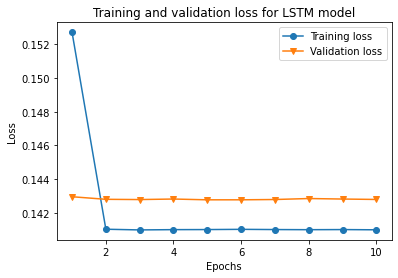

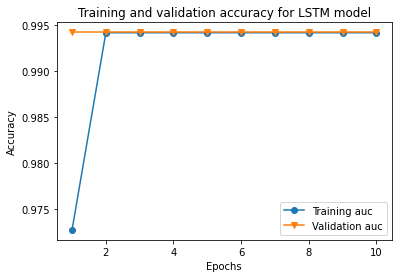

In [23]:
plot_curves(lstm_model,"LSTM")

## **Testing Model**

In [24]:
model.evaluate(x_test,y_test)

499/499 [==============================] - 17s 34ms/step - loss: 0.1389 - accuracy: 0.9940


[0.13888736069202423, 0.9940468668937683]

# **Using Bidirectional layer with LSTM**

## **Defining & training model**

In [25]:
bidirectional_lstm_model = models.Sequential()
bidirectional_lstm_model.add(layers.Embedding(vocab_size, 512, input_length=50))
bidirectional_lstm_model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bidirectional_lstm_model.add(layers.Flatten())
bidirectional_lstm_model.add(layers.Dense(16, activation='relu'))
bidirectional_lstm_model.add(layers.Dense(6, activation='sigmoid'))

bidirectional_lstm_model.compile(loss = "binary_crossentropy" , optimizer = "Adamax" , metrics = ["accuracy"] )
trained_bidirectional_lstm_model = bidirectional_lstm_model.fit(x_train, y_train , validation_split = .2 , batch_size = 512 , epochs = 10)

Epoch 1/10
225/225 [==============================] - 102s 434ms/step - loss: 0.1120 - accuracy: 0.6778 - val_loss: 0.0623 - val_accuracy: 0.9940
Epoch 2/10
225/225 [==============================] - 97s 431ms/step - loss: 0.0564 - accuracy: 0.9939 - val_loss: 0.0573 - val_accuracy: 0.9941
Epoch 3/10
225/225 [==============================] - 105s 468ms/step - loss: 0.0505 - accuracy: 0.9939 - val_loss: 0.0562 - val_accuracy: 0.9942
Epoch 4/10
225/225 [==============================] - 98s 434ms/step - loss: 0.0472 - accuracy: 0.9940 - val_loss: 0.0555 - val_accuracy: 0.9938
Epoch 5/10
225/225 [==============================] - 97s 429ms/step - loss: 0.0451 - accuracy: 0.9840 - val_loss: 0.0570 - val_accuracy: 0.9570
Epoch 6/10
225/225 [==============================] - 97s 429ms/step - loss: 0.0428 - accuracy: 0.9845 - val_loss: 0.0565 - val_accuracy: 0.9881
Epoch 7/10
225/225 [==============================] - 97s 432ms/step - loss: 0.0410 - accuracy: 0.9627 - val_loss: 0.0577 - val_

## **Saving model**

In [26]:
# saving model
import pickle
bidirectional_lstm_model.save("my_2nd_model")
pickle.dump(trained_bidirectional_lstm_model,open("lstm_model.sav","wb"))

In [27]:
# loading model
# import pickle
# bidirectional_lstm_model = model.load("my_2nd_model")
# trained_bidirectional_lstm_model = pickle.load(open("lstm_model.sav","rb"))

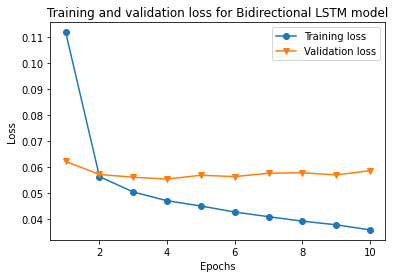

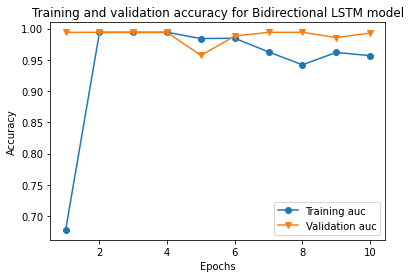

In [28]:
plot_curves(trained_bidirectional_lstm_model,"Bidirectional LSTM")

## **Testing Model**

In [29]:
bidirectional_lstm_model.evaluate(x_test,y_test)

499/499 [==============================] - 17s 34ms/step - loss: 0.0574 - accuracy: 0.9929


[0.05735195800662041, 0.9928562641143799]

# **GRU model**

## **Defining & training model**

In [30]:
bidirectional_gru_model = models.Sequential()
bidirectional_gru_model.add(layers.Embedding(vocab_size, 512, input_length=50))
bidirectional_gru_model.add(layers.Bidirectional(layers.GRU(64)))
bidirectional_gru_model.add(layers.Flatten())
bidirectional_gru_model.add(layers.Dense(6, activation='sigmoid'))

bidirectional_gru_model.compile(loss = "binary_crossentropy" , optimizer = "Adamax" , metrics = ["accuracy"] )
trained_bidirectional_gru_model = bidirectional_gru_model.fit(x_train, y_train , validation_split = .2 , batch_size = 512 , epochs = 10)

Epoch 1/10
225/225 [==============================] - 12s 25ms/step - loss: 0.1303 - accuracy: 0.9181 - val_loss: 0.0630 - val_accuracy: 0.9939
Epoch 2/10
225/225 [==============================] - 5s 23ms/step - loss: 0.0566 - accuracy: 0.9941 - val_loss: 0.0559 - val_accuracy: 0.9942
Epoch 3/10
225/225 [==============================] - 5s 22ms/step - loss: 0.0509 - accuracy: 0.9942 - val_loss: 0.0541 - val_accuracy: 0.9942
Epoch 4/10
225/225 [==============================] - 5s 23ms/step - loss: 0.0478 - accuracy: 0.9942 - val_loss: 0.0535 - val_accuracy: 0.9942
Epoch 5/10
225/225 [==============================] - 5s 23ms/step - loss: 0.0453 - accuracy: 0.9942 - val_loss: 0.0536 - val_accuracy: 0.9942
Epoch 6/10
225/225 [==============================] - 5s 23ms/step - loss: 0.0430 - accuracy: 0.9942 - val_loss: 0.0532 - val_accuracy: 0.9942
Epoch 7/10
225/225 [==============================] - 5s 23ms/step - loss: 0.0410 - accuracy: 0.9942 - val_loss: 0.0547 - val_accuracy: 0.994

## **Saving model**

In [31]:
# saving model
import pickle
bidirectional_gru_model.save("my_3rd_model")
pickle.dump(trained_bidirectional_gru_model,open("gru_model.sav","wb"))

In [32]:
# loading model
# import pickle
# bidirectional_gru_model = model.load("my_3rd_model")
# trained_bidirectional_gru_model = pickle.load(open("gru_model.sav","rb"))

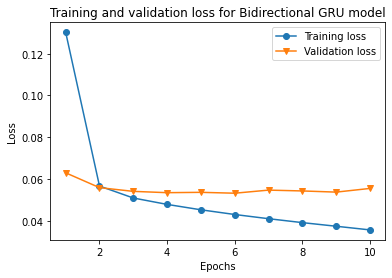

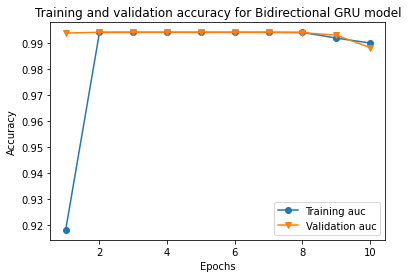

In [33]:
plot_curves(trained_bidirectional_gru_model,"Bidirectional GRU")

## **Testing Model**

In [34]:
bidirectional_gru_model.evaluate(x_test,y_test)

499/499 [==============================] - 2s 4ms/step - loss: 0.0543 - accuracy: 0.9882


[0.05433035269379616, 0.9882190823554993]

# **Conclusion**

Now after training the three models above, if i've to choose one to tune i'd choose the third one (GRU model) since it's training time & accuracy makes it a perfect choice for future enhancements